# 09. 워드 임베딩(Word Embedding)

## 02) 워드투벡터(Word2Vec) 지수

## 03) 영어/한국어 Word2Vec 실습

## 04) 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS) 

## 06) 패스트텍스트(FastText)

## 08) 사전 훈련된 워드 임베딩(Pre-trained Word Embedding) PLM

## 09) 엘모(Embeddings from Language Model, ELMo)

## 10) 임베딩 벡터의 시각화(Embedding Visualization)

---

## 11) 문서 벡터를 이용한 추천 시스템(Recommendation System using Document Embedding)

- 문서들을 고정된 길이의 벡터로 변환한다면 벡터 간 비교로 문서들을 서로 비교할 수 있다
- 각 문서를 문서 벡터로 변환하는 방법은 이미 구현된 패키지인 Doc2Vec이나 Sent2Vec 등을 사용하여 학습하는 방법도 존재하지만, 
<br>

- 이번에는 문서 내 각 단어들을 **Word2Vec**을 통해 단어 벡터로 변환하고, 
- 이들의 평균으로 문서 벡터를 얻어 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템을 만들어보자!

In [1]:
import gensim
print(gensim.__version__)

3.6.0


In [2]:
# 3.6.0 버전 사용
# pip install --upgrade gensim==3.6.0

### 1. 데이터 로드

In [3]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/imok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- 책의 이미지와 책의 줄거리를 크롤링한 데이터

In [5]:
# URL로 표시된 네트워크 객체를 로컬 파일로 복사
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")

('data.csv', <http.client.HTTPMessage at 0x1035f5eb0>)

In [6]:
df = pd.read_csv("data.csv")

In [7]:
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [8]:
df[:5]

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [9]:
# 줄거리에 해당하는 열
df.Desc[:5]

0    We know that power is shifting: From West to E...
1    Following the success of The Accidental Billio...
2    How to tap the power of social software and ne...
3    William J. Bernstein is an American financial ...
4    Amazing book. And I joined Steve Jobs and many...
Name: Desc, dtype: object

- 전처리 수행

In [45]:
# ord(문자) : 해당 문자에 해당하는 유니코드 정수를 반환
# chr(정수) : 해당 정수에 해당하는 유니코드 문자를 반환
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# 구두점 제거
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [46]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [47]:
# 빈 값이 생긴 행이 있다면, nan 값으로 변환 후에 해당 행을 제거
# 2382 (1개 줄어들었음)
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


In [48]:
# 토큰화를 수행하여 corpus라는 리스트에 저장
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [49]:
print(corpus[:1])

[['know', 'power', 'shifting', 'west', 'east', 'north', 'south', 'presidential', 'palaces', 'public', 'squares', 'formidable', 'corporate', 'behemoths', 'nimble', 'startups', 'and', 'slowly', 'surely', 'men', 'women', 'power', 'merely', 'shifting', 'dispersing', 'also', 'decaying', 'power', 'today', 'constrained', 'risk', 'losing', 'ever', 'before', 'end', 'power', 'award', 'winning', 'columnist', 'former', 'foreign', 'policy', 'editor', 'moiss', 'nam', 'illuminates', 'struggle', 'once', 'dominant', 'megaplayers', 'new', 'micropowers', 'challenging', 'every', 'field', 'human', 'endeavor', 'drawing', 'provocative', 'original', 'research', 'nam', 'shows', 'antiestablishment', 'drive', 'micropowers', 'topple', 'tyrants', 'dislodge', 'monopolies', 'open', 'remarkable', 'new', 'opportunities', 'also', 'lead', 'chaos', 'paralysis', 'nam', 'deftly', 'covers', 'seismic', 'changes', 'underway', 'business', 'religion', 'education', 'within', 'families', 'matters', 'war', 'peace', 'examples', 'ab

### 2. 사전 훈련된 워드 임베딩 사용하기

In [15]:
# 다운 너무 오래걸림
# urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                            filename="GoogleNews-vectors-negative300.bin.gz")
# word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

- 데이터가 충분하지 않은 상황에서 사전 훈련된 워드 임베딩을 단어 벡터의 초기값으로 사용하여 성능을 높일 수 있다

In [50]:
word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

### 3. 단어 벡터의 평균 구하기

- 각 문서에 존재하는 단어들의 벡터값의 평균을 구하여 해당 문서의 벡터값을 연산

In [51]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [52]:
document_embedding_list = get_document_vectors(df['cleaned'])

/var/folders/m6/hrff0b7x4hl1m5j8nxchlk5c0000gn/T/ipykernel_8688/913432021.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
/var/folders/m6/hrff0b7x4hl1m5j8nxchlk5c0000gn/T/ipykernel_8688/913432021.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


In [53]:
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 2381


### 4. 추천 시스템 구현하기

- 각 문서 벡터 간의 코사인 유사도를 구한다

In [54]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)

In [55]:
cosine_similarities[0]

array([1.0000002 , 0.81766146, 0.7545086 , ..., 0.8008849 , 0.7526875 ,
       0.7070744 ], dtype=float32)

In [56]:
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


- 선택한 책에 대해서 코사인 유사도를 이용하여 가장 줄거리가 유사한 5개의 책을 찾아내는 함수

In [57]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

In [60]:
df['title']

0       The End of Power: From Boardrooms to Battlefie...
1       Console Wars: Sega, Nintendo, and the Battle t...
2       Trust Agents: Using the Web to Build Influence...
3                           The Four Pillars of Investing
4                     Made in Japan: Akio Morita and Sony
                              ...                        
2377                                             Insomnia
2378                               Murder at the Vicarage
2379                              The Day of the Triffids
2380         A Good Man is Hard to Find and Other Stories
2381                                       Angela's Ashes
Name: title, Length: 2381, dtype: object

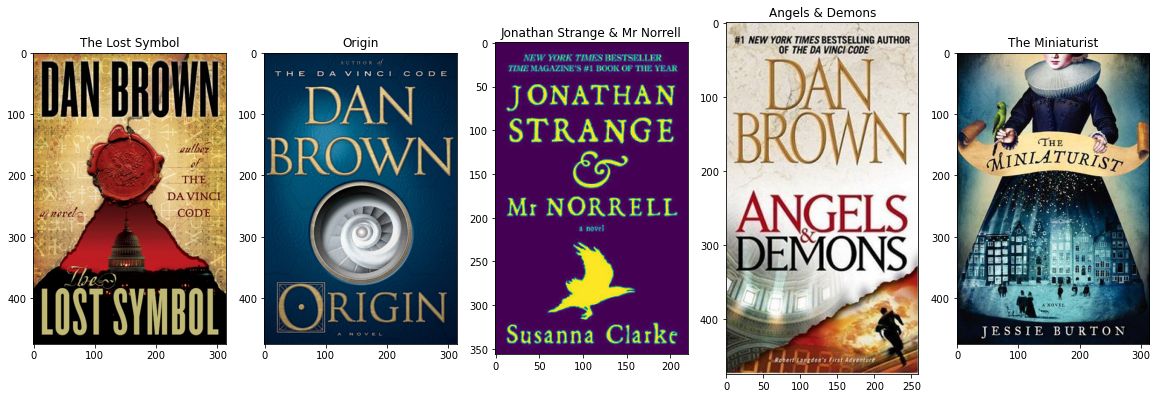

In [58]:
recommendations("The Da Vinci Code")

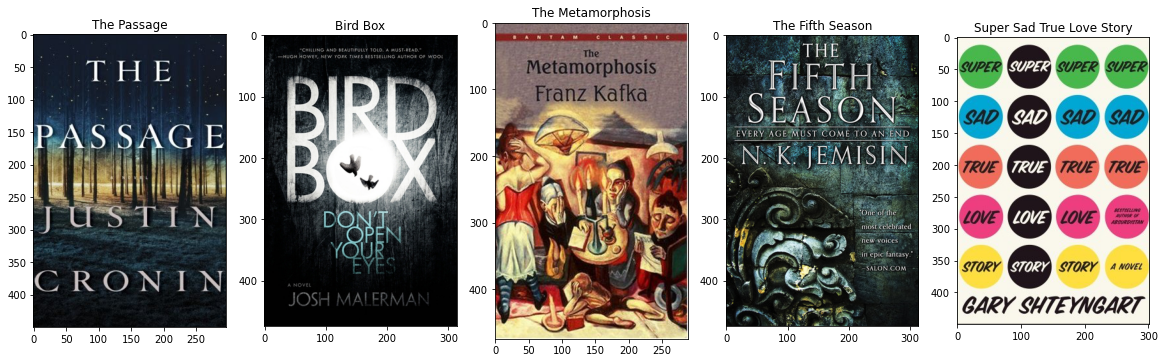

In [61]:
recommendations("Murder at the Vicarage")

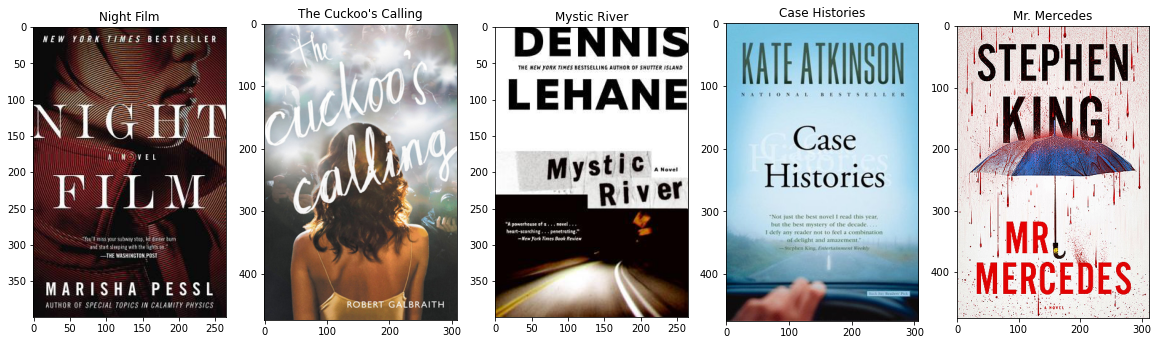

In [62]:
recommendations("The Murder of Roger Ackroyd")

---

## 12) 문서 임베딩 : 워드 임베딩의 평균(Average Word Embedding)

- 임베딩이 잘 된 상황에서는 단어 벡터들의 평균만으로 텍스트 분류를 수행할 수 있음을 보이고, 워드 임베딩의 중요성을 이해하기

In [63]:
import tensorflow as tf
tf.__version__

'2.7.0'

영화 사이트 IMDB 영화 리뷰 데이터
- 리뷰가 긍정인 경우 1을, 부정인 경우 0
- 25,000개의 훈련 데이터와 테스트 데이터 25,000개로 구성

### 1. 데이터 로드와 전처리

In [64]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import imdb

In [66]:
# 등장 빈도 순위가 20,000등이 넘는 단어들은 데이터를 로드할 때 전부 제거
vocab_size = 20000

# num_words = 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지를 사용할 것인지를 의미
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 :',len(X_train))
print('테스트용 리뷰 개수 :',len(X_test))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [71]:
# 훈련 데이터의 첫번째 샘플
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


- 첫번째 리뷰가 긍정 리뷰

In [72]:
# 훈련 데이터의 첫번째 샘플의 레이블
print(y_train[0])

1


In [73]:
print('훈련용 리뷰의 평규 길이: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('테스트용 리뷰의 평균 길이: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

훈련용 리뷰의 평규 길이: 238
테스트용 리뷰의 평균 길이: 230


In [75]:
# 평균보다는 큰 수치인 400으로 패딩
max_len = 400

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print('x_train의 크기(shape) :', X_train.shape)
print('x_test의 크기(shape) :', X_test.shape)

x_train의 크기(shape) : (25000, 400)
x_test의 크기(shape) : (25000, 400)


### 2. 모델 설계하기

- 임베딩 벡터를 평균으로 사용하는 모델을 설계

In [77]:
embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))

# 입력으로 들어오는 모든 벡터들의 평균을 구하는 역할
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

In [78]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('embedding_average_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [79]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
  1/625 [..............................] - ETA: 1:30 - loss: 0.6934 - acc: 0.4375

2022-03-25 22:10:24.876029: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


623/625 [============================>.] - ETA: 0s - loss: 0.6276 - acc: 0.7339
Epoch 00001: val_acc improved from -inf to 0.82140, saving model to embedding_average_model.h5
625/625 [==============================] - 3s 5ms/step - loss: 0.6274 - acc: 0.7343 - val_loss: 0.5194 - val_acc: 0.8214
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.4286 - acc: 0.8554
Epoch 00002: val_acc improved from 0.82140 to 0.86320, saving model to embedding_average_model.h5
625/625 [==============================] - 3s 5ms/step - loss: 0.4286 - acc: 0.8554 - val_loss: 0.3785 - val_acc: 0.8632
Epoch 3/10
619/625 [============================>.] - ETA: 0s - loss: 0.3180 - acc: 0.8926
Epoch 00003: val_acc improved from 0.86320 to 0.88080, saving model to embedding_average_model.h5
625/625 [==============================] - 4s 6ms/step - loss: 0.3175 - acc: 0.8928 - val_loss: 0.3227 - val_acc: 0.8808
Epoch 4/10
620/625 [============================>.] - ETA: 0s - loss: 0.2615 - acc: 

- 별 다른 신경망을 추가하지 않고 단어 벡터의 평균만으로도 88.76%라는 준수한 정확도를 얻어냄

In [80]:
loaded_model = load_model('embedding_average_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 1s 963us/step - loss: 0.2932 - acc: 0.8869

 테스트 정확도: 0.8869


---

## 13) Doc2Vec으로 공시 사업보고서 유사도 계산하기

- Word2Vec은 단어를 임베딩하는 워드 임베딩 알고리즘
- Doc2Vec은 Word2Vec을 변형하여 문서의 임베딩을 얻을 수 있도록 한 알고리즘

- 논문 제목 : Distributed Representations of Sentences and Documents
- 논문 링크 : https://arxiv.org/abs/1405.4053

In [37]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nIUZxASrbIa0Z2xzGVgX1dqjtnFCoKNT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nIUZxASrbIa0Z2xzGVgX1dqjtnFCoKNT" -O dart.csv && rm -rf /tmp/cookies.txt

--2022-03-23 01:46:39--  https://docs.google.com/uc?export=download&confirm=t&id=1nIUZxASrbIa0Z2xzGVgX1dqjtnFCoKNT
docs.google.com (docs.google.com) 해석 중... 142.250.199.110
다음으로 연결 중: docs.google.com (docs.google.com)|142.250.199.110|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 303 See Other
위치: https://doc-04-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ndfjk6dcebcvbrvadj8suv48hoj4kgh3/1647967575000/17609157229046208934/*/1nIUZxASrbIa0Z2xzGVgX1dqjtnFCoKNT?e=download [따라감]
경고: HTTP에 와일드카드 문자를 지원하지 않습니다.
--2022-03-23 01:46:39--  https://doc-04-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ndfjk6dcebcvbrvadj8suv48hoj4kgh3/1647967575000/17609157229046208934/*/1nIUZxASrbIa0Z2xzGVgX1dqjtnFCoKNT?e=download
doc-04-7k-docs.googleusercontent.com (doc-04-7k-docs.googleusercontent.com) 해석 중... 142.251.42.161
다음으로 연결 중: doc-04-7k-docs.googleusercontent.com (doc-04-7k-docs.googleusercontent.com)|142.251.42.161|:443... 연결했습니다.
HTTP 요청을 보

- 전자공시시스템(Dart)에 올라와있는 각 회사의 사업보고서를 Doc2Vec을 통해서 학습시키고, 
- 특정 회사와 사업 보고서가 유사한 회사들을 찾아보는 실습

### 1. 공시 사업 보고서 로드 및 전처리

In [81]:
import pandas as pd
from konlpy.tag import Mecab
from gensim.models.doc2vec import TaggedDocument

In [82]:
from tqdm import tqdm

In [83]:
df = pd.read_csv('./dart.csv',  sep=',')

In [84]:
df = df.dropna()
df

,code,market,name,business
0,000020,KOSPI,동화약품,II. 사업의 내용\n1. 사업의 개요\n가. 일반적인 사항\n기업회계기준서 제11...
1,000040,KOSPI,KR모터스,II. 사업의 내용\n1. 사업의 개요\n가. 업계의 현황\n수출주력시장인 유럽 불...
2,000050,KOSPI,경방,II. 사업의 내용\n1. 사업의 개요\n(1) 산업의 특성\n[섬유사업부문]\n면...
3,000060,KOSPI,메리츠화재,"II. 사업의 내용\n1. 사업의 개요\n가. 산업의 특성, 성장성, 경기변동의 특..."
4,000070,KOSPI,삼양홀딩스,"II. 사업의 내용\n1. 사업의 개요\n가. 업계의 현황\n지주회사(持株會社, H..."
...,...,...,...,...
2582,950130,KOSDAQ,엑세스바이오,II. 사업의 내용\n1. 사업의 개\n요\n당사는 체외진단 기술을 토대로 말라리아...
2583,950140,KOSDAQ,잉글우드랩,II. 사업의 내용\n1. 사업의 개요\n가. 화장품 ODM산업 개요\nODM은 O...
2584,950160,KOSDAQ,코오롱티슈진,II. 사업의 내용\n당사는 1999년 6월 9일 세포 유전자 기술 Platform...
2585,950170,KOSDAQ,JTC,II. 사업의 내용\n1. 사업의 개요\n가. 업계의 현황\n(1) 산업의 특성\n...


- code : 종목 번호
- market : 해당 종목이 KOSPI인지 KOSDAQ인지
- name : 회사명에
- business : 사업 보고서

### Doc2Vec

- Doc2Vec 학습을 위해서는 해당 문서의 '제목'과 단어 토큰화가 된 상태의 해당 문서의 '본문' 두 가지가 필요

In [89]:
mecab = Mecab()

In [90]:
tagged_corpus_list = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['business']
    tag = row['name']
    # tags에 해당 문서의 '제목'을, 그리고 words에 해당 문서의 '본문'에 해당하는 단어 토큰화 결과를 저장
    tagged_corpus_list.append(TaggedDocument(tags=[tag], words=mecab.morphs(text)))

100%|███████████████████████████████████████████████████| 2295/2295 [00:39<00:00, 58.20it/s]


In [91]:
print('문서의 수 :', len(tagged_corpus_list))

문서의 수 : 2295


In [94]:
# words에는 토큰화 된 사업 보고서
# tags=['동화약품']
tagged_corpus_list[0]

TaggedDocument(words=['II', '.', '사업', '의', '내용', '1', '.', '사업', '의', '개요', '가', '.', '일반', '적', '인', '사항', '기업', '회계', '기준', '서', '제', '1110', '호', '"', '연결', '재무제표', '"', '의', '의하', '여', '2018', '년', '12', '월', '17', '일', '에', '설립', '한', '동화', '크립톤', '기업가', '정신', '제일', '호', '창업', '벤처', '전문', '사모', '투자', '합자회사', '를', '종속', '회사', '에', '편입', '하', '였', '습니다', '.', '나', '.', '지배', '기업', '의', '현황', '1', ')', '산업', '의', '특성', '제약', '산업', '은', '약학', ',', '화학', ',', '생물학', '등', '여러', '분야', '의', '지식', '과', '기술', '이', '복합', '적', '으로', '필요', '한', '기술', '·', '지식', '집약', '형', '산업', '으로', '인간', '의', '생명', '과', '보건', '에', '직접', '적', '으로', '관련', '된', '제품', '을', '생산', '하', '고', ',', '개발', '·', '제조', '·', '유통', '·', '가격', '등', '을', '정부', '에서', '엄격', '하', '게', '규제', '하', '고', '관리', '하', '는', '산업', '적', '특성', '을', '가지', '고', '있', '습니다', '.', '또한', '신약', '개발', '에', '는', '막대', '한', '시간', '과', '비용', '이', '소요', '되', '며', ',', '성공', '확률', '또한', '높', '지', '않', '으나', '신약', '개발', '에', '성공', '할', '경우', '엔', '엄청난

### 2. Doc2Vec 학습 및 테스트

In [95]:
from gensim.models import doc2vec

아래 코드는 굉장히 오래 걸립니다. 1시간 이상 걸릴 수도 있습니다.

In [ ]:
model = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, workers=8, window=8)

# Vocabulary 빌드
model.build_vocab(tagged_corpus_list)

print(f"Tag Size: {len(model.docvecs.doctags.keys())}", end=' / ')

# Doc2Vec 학습
model.train(tagged_corpus_list, total_examples=model.corpus_count, epochs=50)

# 모델 저장
model.save('dart.doc2vec')

코드를 다 수행하고나면 3개의 파일이 생깁니다.  
* dart.doc2vec  
* dart.doc2vec.trainables.syn1neg.npy  
* dart.doc2vec.wv.vectors.npy


여러분들이 1시간 이상 기다릴 수는 없으므로 제가 이미 만들어놓은 파일들을 다운로드하여 실습을 진행합니다.

In [48]:
# dart.doc2vec 파일 다운로드
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HyGiCxE748kt3dAhHTHxHHHMjj0VcpMY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HyGiCxE748kt3dAhHTHxHHHMjj0VcpMY" -O dart.doc2vec && rm -rf /tmp/cookies.txt

sed: RE error: illegal byte sequence
--2022-03-23 01:48:52--  https://docs.google.com/uc?export=download&confirm=&id=1HyGiCxE748kt3dAhHTHxHHHMjj0VcpMY
docs.google.com (docs.google.com) 해석 중... 142.250.199.110
다음으로 연결 중: docs.google.com (docs.google.com)|142.250.199.110|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 303 See Other
위치: https://doc-08-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9li2i7ar5gvqrgi4d50fija88jeps8jf/1647967725000/17609157229046208934/*/1HyGiCxE748kt3dAhHTHxHHHMjj0VcpMY?e=download [따라감]
경고: HTTP에 와일드카드 문자를 지원하지 않습니다.
--2022-03-23 01:48:53--  https://doc-08-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9li2i7ar5gvqrgi4d50fija88jeps8jf/1647967725000/17609157229046208934/*/1HyGiCxE748kt3dAhHTHxHHHMjj0VcpMY?e=download
doc-08-7k-docs.googleusercontent.com (doc-08-7k-docs.googleusercontent.com) 해석 중... 142.251.42.161
다음으로 연결 중: doc-08-7k-docs.googleusercontent.com (doc-08-7k-docs.googleusercontent.com)|142.2

In [49]:
# dart.doc2vec.trainables.syn1neg.npy 파일 다운로드
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3" -O dart.doc2vec.trainables.syn1neg.npy && rm -rf /tmp/cookies.txt

--2022-03-23 01:48:58--  https://docs.google.com/uc?export=download&confirm=&id=1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3
docs.google.com (docs.google.com) 해석 중... 142.250.199.110
다음으로 연결 중: docs.google.com (docs.google.com)|142.250.199.110|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 303 See Other
위치: https://doc-0o-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sueam7gdvhb127i2i6ifc858jh4es0r8/1647967725000/17609157229046208934/*/1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3?e=download [따라감]
경고: HTTP에 와일드카드 문자를 지원하지 않습니다.
--2022-03-23 01:48:59--  https://doc-0o-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sueam7gdvhb127i2i6ifc858jh4es0r8/1647967725000/17609157229046208934/*/1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3?e=download
doc-0o-7k-docs.googleusercontent.com (doc-0o-7k-docs.googleusercontent.com) 해석 중... 142.251.42.161
다음으로 연결 중: doc-0o-7k-docs.googleusercontent.com (doc-0o-7k-docs.googleusercontent.com)|142.251.42.161|:443... 연결했습니다.
HTTP 요청을 보냈

In [47]:
# dart.doc2vec.wv.vectors.npy 파일 다운로드
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tZOkSypiT0djwAZOInFnnQrJO9rGOdv2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3" -O dart.doc2vec.wv.vectors.npy && rm -rf /tmp/cookies.txt

sed: RE error: illegal byte sequence
--2022-03-23 01:48:25--  https://docs.google.com/uc?export=download&confirm=&id=1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3
docs.google.com (docs.google.com) 해석 중... 142.250.199.110
다음으로 연결 중: docs.google.com (docs.google.com)|142.250.199.110|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 303 See Other
위치: https://doc-0o-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jtbpqpa5d22884q080atls0i0ceof6od/1647967650000/17609157229046208934/*/1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3?e=download [따라감]
경고: HTTP에 와일드카드 문자를 지원하지 않습니다.
--2022-03-23 01:48:27--  https://doc-0o-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jtbpqpa5d22884q080atls0i0ceof6od/1647967650000/17609157229046208934/*/1XTgLCu0BmLPpaU960po3YWZsGYMNH7r3?e=download
doc-0o-7k-docs.googleusercontent.com (doc-0o-7k-docs.googleusercontent.com) 해석 중... 142.251.42.161
다음으로 연결 중: doc-0o-7k-docs.googleusercontent.com (doc-0o-7k-docs.googleusercontent.com)|142.2

In [50]:
%ls

11-0.txt                             char_rnn.ipynb
Deep_Learning.ipynb                  dart.csv
GoogleNews-vectors-negative300.bin   dart.doc2vec
Machine_Learning.ipynb               dart.doc2vec.trainables.syn1neg.npy
New_York_Times_Comments/             dart.doc2vec.wv.vectors.npy
Recurrent_Neural_Network.ipynb       data.csv
Text_preprocessing.ipynb             embedding_average_model.h5
Word Embedding.ipynb                 imok_lib.ipynb


In [96]:
# 모델을 로드합니다.
model = doc2vec.Doc2Vec.load('dart.doc2vec')

In [97]:
similar_doc = model.docvecs.most_similar('동화약품')
print(similar_doc)

[('종근당', 0.5402344465255737), ('동아에스티', 0.5081683397293091), ('제일약품', 0.5039623975753784), ('일양약품', 0.5026872158050537), ('영진약품', 0.5019735097885132), ('경동제약', 0.4943977892398834), ('동국제약', 0.4866287112236023), ('삼일제약', 0.4839821457862854), ('대웅제약', 0.48174917697906494), ('제일파마홀딩스', 0.48122021555900574)]


In [98]:
similar_doc = model.docvecs.most_similar('하이트진로')
print(similar_doc)

[('하이트진로홀딩스', 0.8503450155258179), ('보해양조', 0.5050876140594482), ('무학', 0.49451184272766113), ('롯데칠성', 0.4889701008796692), ('국순당', 0.462422251701355), ('삼광글라스', 0.40693792700767517), ('해태제과식품', 0.40258675813674927), ('오리온', 0.4004286527633667), ('이마트', 0.38732242584228516), ('삼양패키징', 0.38403236865997314)]


In [99]:
similar_doc = model.docvecs.most_similar('LG이노텍')
print(similar_doc)

[('LG전자', 0.5431638956069946), ('LG', 0.5402802228927612), ('삼성전기', 0.4997377395629883), ('LG디스플레이', 0.48769694566726685), ('서울반도체', 0.4567990303039551), ('서울바이오시스', 0.44705283641815186), ('루멘스', 0.4344988465309143), ('파트론', 0.41242146492004395), ('코아시아', 0.4108962416648865), ('큐엠씨', 0.409607470035553)]


In [55]:
similar_doc = model.docvecs.most_similar('메리츠화재')
print(similar_doc)

[('메리츠금융지주', 0.7366067171096802), ('한화손해보험', 0.6667637825012207), ('흥국화재', 0.6615817546844482), ('DB손해보험', 0.6544990539550781), ('한화생명', 0.6511871814727783), ('롯데손해보험', 0.6503965258598328), ('현대해상', 0.5851550102233887), ('삼성화재', 0.5822403430938721), ('미래에셋생명', 0.5596811175346375), ('코리안리', 0.558484673500061)]


In [56]:
similar_doc = model.docvecs.most_similar('카카오')
print(similar_doc)

[('네오위즈', 0.5113424062728882), ('NAVER', 0.5021803379058838), ('카카오게임즈', 0.499011754989624), ('TJ미디어', 0.4807787537574768), ('퓨쳐스트림네트웍스', 0.47891443967819214), ('네오위즈홀딩스', 0.4775955080986023), ('베스파', 0.47306525707244873), ('컴투스', 0.46883001923561096), ('엠게임', 0.4585267901420593), ('액토즈소프트', 0.4581746459007263)]
